## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import datetime

import math
import numpy as np
import pandas as pd

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV, ElasticNet
from xgboost import XGBRegressor
import catboost as cb
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, make_scorer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.compose import make_column_selector as selector

## Configs

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

## Load Data

In [3]:
dir_path = '/kaggle/input/store-sales-time-series-forecasting/'

oil_df = pd.read_csv(dir_path + 'oil.csv')
holidays_df = pd.read_csv(dir_path + 'holidays_events.csv')
stores_df = pd.read_csv(dir_path + 'stores.csv')
train_df = pd.read_csv(dir_path + 'train.csv')
test_df = pd.read_csv(dir_path + 'test.csv')
trnsctns_df = pd.read_csv(dir_path + 'transactions.csv')
submissions_df = pd.read_csv(dir_path + 'sample_submission.csv')

In [4]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [5]:
holidays_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [6]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [8]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [9]:
trnsctns_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [10]:
submissions_df.head()

,id,sales
0,3000888,0.00
1,3000889,0.00
2,3000890,0.00
3,3000891,0.00
4,3000892,0.00


## Data Pre-processing

#### Change 'date' column type

In [11]:
oil_df['date'] = pd.to_datetime(oil_df['date'], format = "%Y-%m-%d")
holidays_df['date'] = pd.to_datetime(holidays_df['date'], format = "%Y-%m-%d")
trnsctns_df['date'] = pd.to_datetime(trnsctns_df['date'], format = "%Y-%m-%d")
train_df['date'] = pd.to_datetime(train_df['date'], format = "%Y-%m-%d")
test_df['date'] = pd.to_datetime(test_df['date'], format = "%Y-%m-%d")

#### Fill missing values in datasets

In [12]:
train_data_strt_dt = train_df['date'].min()
train_data_end_dt = train_df['date'].max()
train_dt_rnge = pd.date_range(start=train_data_strt_dt, end=train_data_end_dt)
train_missing_dts = train_dt_rnge.difference(train_df['date'])

test_data_strt_dt = test_df['date'].min()
test_data_end_dt = test_df['date'].max()
test_dt_rnge = pd.date_range(start=test_data_strt_dt, end=test_data_end_dt)
test_missing_dts = test_dt_rnge.difference(test_df['date'])

print(f"Missing dates in training set: {train_missing_dts}")
print(f"Missing dates in test set: {test_missing_dts}")

Missing dates in training set: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)
Missing dates in test set: DatetimeIndex([], dtype='datetime64[ns]', freq=None)


Create a Multi-index variable

In [13]:
multi_index = pd.MultiIndex.from_product([pd.date_range(train_data_strt_dt, train_data_end_dt),
                                          train_df.store_nbr.unique(),
                                          train_df.family.unique()],
                                         names=['date','store_nbr','family'],)
train_df = train_df.set_index(['date','store_nbr','family']).reindex(multi_index).reset_index()

train_df.head()

,date,store_nbr,family,id,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,0.00
1,2013-01-01,1,BABY CARE,1.00,0.00,0.00
2,2013-01-01,1,BEAUTY,2.00,0.00,0.00
3,2013-01-01,1,BEVERAGES,3.00,0.00,0.00
4,2013-01-01,1,BOOKS,4.00,0.00,0.00


Fill missing values with 0s

In [14]:
train_df[['sales','onpromotion']] = train_df[['sales','onpromotion']].fillna(0.)

# Apply linear interpolation to the "id" column to estimate the missing values based on the linear relationship between adjacent data points. 
train_df.id = train_df.id.interpolate(method="linear")

Add an additional column in both training and test sets to separate those two

In [15]:
train_df['test'] = 0
test_df['test'] = 1

#### Oil Data - Re-index by adding missing dates

In [16]:
# Create a date range from the start of training data to the end of test data
date_range = pd.date_range(train_data_strt_dt, test_data_end_dt)

# Create a DataFrame with the date range
date_df = pd.DataFrame({'date': date_range})

# Merge the date_df with oil_df using an outer join
oil_df = oil_df.merge(date_df, on = 'date', how = 'outer')

# Sort the DataFrame by date and reset the index
oil_df = oil_df.sort_values('date', ignore_index=True)

# fill missing values using linear interpolation
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate(method="linear", limit_direction="both")

oil_df.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.15


#### Transactions Data - Fill in the missing values for transactions using interpolation, except for days with zero sales

In [17]:
# Calculate the number of unique store numbers
num_store = train_df['store_nbr'].nunique()

# Calculate the number of days in the training period
train_len = (train_data_end_dt - train_data_strt_dt).days + 1

# Calculate the number of records where sales are zero
num_zero_sales = (train_df.groupby(["date", "store_nbr"])['sales'].sum() == 0).sum()

# Calculate the total number of expected records
total_rec = num_store * train_len

# Calculate the current number of records
curr_rec = len(trnsctns_df.index)

# Calculate the number of missing records
missing_rec = total_rec - curr_rec - num_zero_sales

# Total sales for each store
store_sales = train_df.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# Re-index transaction data
trnsctns_df = trnsctns_df.merge(store_sales, on=["date", "store_nbr"],how="outer").sort_values(["date", "store_nbr"],ignore_index=True)


# Fill missing values with 0s for days with zero sales
trnsctns_df.loc[trnsctns_df.sales.eq(0), "transactions"] = 0

# Drop the "sales" column
trnsctns_df = trnsctns_df.drop(columns=["sales"])

# Fill remaining missing values using linear interpolation within each "store_nbr" group
trnsctns_df["transactions"] = trnsctns_df.groupby("store_nbr")["transactions"].transform(lambda x: x.interpolate(method="linear", limit_direction="both"))

#### Holidays Data - Remove transferred holidays, and separate work days from the main DataFrame for further analysis

In [18]:
# Define a function to process holiday descriptions
def process_holiday(s):
    # Check if "futbol" is in the description; if so, return "futbol"
    if "futbol" in s:
        return "futbol"
    
    # Create a list of words to remove based on cities and states
    to_remove = list(set(stores_df['city'].str.lower()) | set(stores_df['state'].str.lower()))
    
    # Iterate through the list of words and remove them from the description
    for w in to_remove:
        s = s.replace(w, "")
    
    # Return the processed description
    return s

In [19]:
# Clean and process the 'description' column in the holidays_data DataFrame
holidays_df['description'] = holidays_df.apply(lambda x: x['description'].lower().replace(x['locale_name'].lower(), ""), axis=1).apply(process_holiday).replace(r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True).replace(r"\s+|-", " ", regex=True).str.strip()

# Remove transferred holidays from the DataFrame
holidays_df = holidays_df[holidays_df['transferred'].eq(False)]

# Extract and process work days
work_days = holidays_df[holidays_df['type'].eq("Work Day")]
work_days = work_days[["date", "type"]].rename(columns={"type": "work_day"}).reset_index(drop=True)

# Convert the 'work_day' column to binary values (1 for work days, 0 for others)
work_days['work_day'] = work_days['work_day'].notna().astype(int)

# Remove work days from the main holidays_data DataFrame
holidays_df = holidays_df[holidays_df['type']!="Work Day"].reset_index(drop=True)

holidays_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False


Local holidays at city level with dummy variables for descriptions

In [20]:
# Filter local holidays at the city level
local_holidays = holidays_df[holidays_df['locale'].eq("Local")]

# Select relevant columns, rename 'locale_name' to 'city', and reset the index
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(columns={"locale_name": "city"}).reset_index(drop=True)

# Remove duplicated rows
local_holidays = local_holidays[~local_holidays.duplicated()]

# Create dummy variables for 'description' and prefix them with "loc"
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

# Display the resulting DataFrame
local_holidays.head()

,date,city,loc_cantonizacion,loc_fundacion,loc_independencia
0,2012-03-02,Manta,False,True,False
1,2012-04-12,Cuenca,False,True,False
2,2012-04-14,Libertad,True,False,False
3,2012-04-21,Riobamba,True,False,False
4,2012-05-12,Puyo,True,False,False


Regional holidays are filtered and processed to include a binary column indicating whether the description contains "provincializacion."

In [21]:
# Filter regional holidays
regional_holidays = holidays_df[holidays_df['locale'].eq("Regional")]

# Select relevant columns and rename 'locale_name' to 'state' and 'description' to 'provincializacion'
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(columns={"locale_name": "state", "description": "provincializacion"}).reset_index(drop=True)

# Create a binary column 'provincializacion' based on the presence of the word "provincializacion" in descriptions
regional_holidays['provincializacion'] = regional_holidays['provincializacion'].eq("provincializacion").astype(int)

# Return the resulting DataFrame
regional_holidays.head()

,date,state,provincializacion
0,2012-04-01,Cotopaxi,1
1,2012-06-25,Imbabura,1
2,2012-11-06,Santo Domingo de los Tsachilas,1
3,2012-11-07,Santa Elena,1
4,2013-04-01,Cotopaxi,1


National holidays are filtered, processed, and organized for further analysis.

In [22]:
# Filter national holidays
national_holidays = holidays_df[holidays_df['locale'].eq("National")]

# Select relevant columns and reset the index
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)

# Remove duplicated rows
national_holidays = national_holidays[~national_holidays.duplicated()]

# Create dummy variables for 'description' and prefix them with "nat"
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")

# Group national holidays that fall on the same date and sum the binary values
national_holidays = national_holidays.groupby("date").sum().reset_index()

# Rename columns for visualization purposes
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

# Return the resulting DataFrame
national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2012-12-21,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#### Pivot and reshape data into time series format for Sales, Transactions, and Promotions.

In [23]:
# Pivot the train_data DataFrame to create a time series of sales data
sales_ts = pd.pivot_table(train_df, values="sales", index="date", columns=["store_nbr", "family"])

# Pivot the transactions_data DataFrame to create a time series of transaction data
tr_ts = pd.pivot_table(trnsctns_df, values="transactions", index="date", columns="store_nbr")

# Pivot the train_data DataFrame to create a time series of promotion data
promo_ts = pd.pivot_table(train_df, values="onpromotion", index="date", columns=["store_nbr", "family"])

In [24]:
sales_ts.head()

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01       0.00      0.00   0.00      0.00  0.00         0.00   
2013-01-02       2.00      0.00   2.00   1091.00  0.00       470.65   
2013-01-03       3.00      0.00   0.00    919.00  0.00       310.65   
2013-01-04       3.00      0.00   3.00    953.00  0.00       198.37   
2013-01-05       5.00      0.00   3.00   1160.00  0.00       301.06   

store_nbr                                                                    \
family     CELEBRATION CLEANING  DAIRY   DELI   EGGS FROZEN FOODS GROCERY I   
date                                                                          
2013-01-01        0.00     0.00   0.00   0.00   0.00         0.00      0.00   
2013-01-02        0.00  1060.00 579.00 164.07 246.00       131.00   2652.00   
2013-01-03        0.00   836.00 453.00 151.58 203.00        87.04   2121.00   
2013-01-04        0.00   827.00 460.00 131.41 171.00        65.00   2056.00   
2013-01-05        0.00   811.00 464.00 118.61 177.00        70.00   2216.00   

store_nbr                                                              \
family     GROCERY II HARDWARE HOME AND KITCHEN I HOME AND KITCHEN II   
date                                                                    
2013-01-01       0.00     0.00               0.00                0.00   
2013-01-02      31.00     3.00               0.00                0.00   
2013-01-03      12.00     1.00               0.00                0.00   
2013-01-04      15.00     7.00               0.00                0.00   
2013-01-05      30.00     1.00               0.00                0.00   

store_nbr                                                                 \
family     HOME APPLIANCES HOME CARE LADIESWEAR LAWN AND GARDEN LINGERIE   
date                                                                       
2013-01-01            0.00      0.00       0.00            0.00     0.00   
2013-01-02            0.00      0.00       0.00           10.00    13.00   
2013-01-03            2.00      0.00       0.00            0.00    15.00   
2013-01-04            0.00      0.00       0.00            7.00    24.00   
2013-01-05            0.00      0.00       0.00           10.00    20.00   

store_nbr                                                                \
family     LIQUOR,WINE,BEER MAGAZINES  MEATS PERSONAL CARE PET SUPPLIES   
date                                                                      
2013-01-01             0.00      0.00   0.00          0.00         0.00   
2013-01-02            67.00      0.00 369.10        194.00         0.00   
2013-01-03            66.00      0.00 272.32        153.00         0.00   
2013-01-04           102.00      0.00 454.17         88.00         0.00   
2013-01-05           159.00      0.00 328.94        141.00         0.00   

store_nbr                                                          \
family     PLAYERS AND ELECTRONICS POULTRY PREPARED FOODS PRODUCE   
date                                                                
2013-01-01                    0.00    0.00           0.00    0.00   
2013-01-02                    0.00  247.30          47.00    0.00   
2013-01-03                    0.00  187.28          63.00    0.00   
2013-01-04                    0.00  258.02          67.00    0.00   
2013-01-05                    0.00  212.33          66.00    0.00   

store_nbr                                             2                    \
family     SCHOOL AND OFFICE SUPPLIES SEAFOOD AUTOMOTIVE BABY CARE BEAUTY   
date                                                                        
2013-01-01                       0.00    0.00       0.00      0.00   0.00   
2013-01-02                       0.00   38.03       8.00      0.00   3.00   
2013-01-03                       0.00   17.37       5.00      0.0

#### Create master dataset for time series analysis

In [25]:
# scale target series
scaler = MinMaxScaler()
sales_ts_scaled = sales_ts.copy()
sales_ts_scaled[sales_ts_scaled.columns] = scaler.fit_transform(sales_ts_scaled)

# convert back to long form and add the holiday columns
holiday_sales_merged = sales_ts_scaled.melt(
    value_name="sales", ignore_index=False,).reset_index().\
    merge(stores_df, on="store_nbr", how="left").\
    merge(work_days, on="date", how="left").\
    merge(local_holidays, on=["date", "city"], how="left").\
    merge(regional_holidays, on=["date", "state"], how="left").\
    merge(national_holidays, on="date", how="left").\
    fillna(0)

# include dummy variable for dates without any holidays
holiday_list = [col for col in holiday_sales_merged if col.startswith(("loc_", "nat_", "provincializacion"))]
holiday_sales_merged["no_holiday"] = holiday_sales_merged[holiday_list].sum(axis=1).eq(0).astype(int)

holiday_sales_merged.head()

,date,store_nbr,family,sales,city,state,type,cluster,work_day,loc_cantonizacion,loc_fundacion,loc_independencia,provincializacion,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo,no_holiday
0,2013-01-01,1,AUTOMOTIVE,0.00,Quito,Pichincha,D,13,0.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0
1,2013-01-02,1,AUTOMOTIVE,0.11,Quito,Pichincha,D,13,0.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
2,2013-01-03,1,AUTOMOTIVE,0.16,Quito,Pichincha,D,13,0.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
3,2013-01-04,1,AUTOMOTIVE,0.16,Quito,Pichincha,D,13,0.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
4,2013-01-05,1,AUTOMOTIVE,0.26,Quito,Pichincha,D,13,1.00,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


Merge data

In [26]:
# Define a list of selected national holidays with larger impacts on sales
selected_holidays = ["nat_terremoto", "nat_navidad", "nat_dia la madre", "nat_dia trabajo",
                     "nat_primer dia ano", "nat_futbol", "nat_dia difuntos"]

# Select only the columns related to the selected national holidays
keep_national_holidays = national_holidays[["date", *selected_holidays]]


# Concatenate the train and test data along the rows
data = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# Merge the 'stores_data' DataFrame on the 'store_nbr' column
data = data.merge(stores_df, on=["store_nbr"])

# Merge the 'oil_data' DataFrame on the 'date' column, with a left join
data = data.merge(oil_df, on=["date"], how="left")

# Merge the 'transactions_data' DataFrame on the 'date' and 'store_nbr' columns, with a left join
data = data.merge(trnsctns_df, on=["date", 'store_nbr'], how="left")

# Merge the 'work_days' DataFrame on the 'date' column, with a left join
data = data.merge(work_days, on="date", how="left")

# Merge the 'keep_national_holidays' DataFrame on the 'date' column, with a left join
data = data.merge(keep_national_holidays, on=["date"], how="left")

# Sort the resulting dataset by 'date', 'store_nbr', and 'family' columns
data = data.sort_values(["date", "store_nbr", "family"], ignore_index=True)


# The last section of code fills missing values in the 'work_day' and selected holiday columns with 0:
data[["work_day", *selected_holidays]] = data[["work_day", *selected_holidays]].fillna(0)

data.head()

,date,store_nbr,family,id,sales,onpromotion,test,city,state,type,cluster,dcoilwtico,transactions,work_day,nat_terremoto,nat_navidad,nat_dia la madre,nat_dia trabajo,nat_primer dia ano,nat_futbol,nat_dia difuntos
0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1,2013-01-01,1,BABY CARE,1.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,2013-01-01,1,BEAUTY,2.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,2013-01-01,1,BEVERAGES,3.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,2013-01-01,1,BOOKS,4.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


## Feature Engineering

Add new columns that provide temporal information about the data

In [27]:
# Select the date, days of the week, hours, month (not used in calculations)
data['day_of_week'] = data.date.dt.dayofweek
data['day_of_year'] = data.date.dt.dayofyear
data['day_of_month'] = data.date.dt.day
data['year'] = data.date.dt.year
data['month'] = data.date.dt.month

# Seasons: 0-winter; 1-spring; 2-summer; 3-fall
data["season"] = np.where(data.date.dt.month.isin([12, 1, 2]), 0, 1)
data["season"] = np.where(data.date.dt.month.isin([3, 4, 5]), 1, data["season"])
data["season"] = np.where(data.date.dt.month.isin([6, 7, 8]), 2, data["season"])
data["season"] = np.where(data.date.dt.month.isin([9, 10, 11]), 3, data["season"])

In the EDA, it was found that the sales across stores are distributed unevenly. If there are any memory limitations, we will consider only a part of the stores

In [28]:
#Let's keep data for 1-20 stores, due to the lack of memory
#data = data.loc[data['store_nbr'].isin(list(range(1, 19)))]

In [29]:
# Create a copy of the original data
data_analyses = data.copy()

# Specify the target variable
target = 'sales'

# Separate the data into training and testing sets based on the 'test' column
train = data_analyses.loc[data_analyses['test'] == 0]
test = data_analyses.loc[data_analyses['test'] == 1]

train.head()

,date,store_nbr,family,id,sales,onpromotion,test,city,state,type,cluster,dcoilwtico,transactions,work_day,nat_terremoto,nat_navidad,nat_dia la madre,nat_dia trabajo,nat_primer dia ano,nat_futbol,nat_dia difuntos,day_of_week,day_of_year,day_of_month,year,month,season
0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0
1,2013-01-01,1,BABY CARE,1.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0
2,2013-01-01,1,BEAUTY,2.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0
3,2013-01-01,1,BEVERAGES,3.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0
4,2013-01-01,1,BOOKS,4.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0


In [30]:
# Rolling Summary Stats Features
#A rolling mean is simply the mean of a certain number of previous periods in a time series.
for i in [16,17,18,19,20,21,22,46,76,106,365, 730]:
    data_analyses["sales_roll_mean_"+str(i)]=data_analyses.groupby(["store_nbr", "family"])['sales'].rolling(i).mean().shift(1).values

#### Lag/ Shifted Features

In [31]:
data_analyses.sort_values(by=['store_nbr', 'family', 'date'], axis=0, inplace=True)

In [32]:
def lag_features(dataframe, lags, groups = ["store_nbr", "family"], target = "sales", prefix = ''):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe[prefix + str(lag)] = dataframe.groupby(groups)[target].transform(lambda x: x.shift(lag))
    return dataframe

In [33]:
#Let's create lags
data_analyses = lag_features(data_analyses, 
                             lags = [16,17,18,19,20,21,22,46,76,106,365, 730],
                             groups = ["store_nbr", "family"], target = 'sales', 
                             prefix = 'sales_lag_')
data_analyses.head(20)

,date,store_nbr,family,id,sales,onpromotion,test,city,state,type,cluster,dcoilwtico,transactions,work_day,nat_terremoto,nat_navidad,nat_dia la madre,nat_dia trabajo,nat_primer dia ano,nat_futbol,nat_dia difuntos,day_of_week,day_of_year,day_of_month,year,month,season,sales_roll_mean_16,sales_roll_mean_17,sales_roll_mean_18,sales_roll_mean_19,sales_roll_mean_20,sales_roll_mean_21,sales_roll_mean_22,sales_roll_mean_46,sales_roll_mean_76,sales_roll_mean_106,sales_roll_mean_365,sales_roll_mean_730,sales_lag_16,sales_lag_17,sales_lag_18,sales_lag_19,sales_lag_20,sales_lag_21,sales_lag_22,sales_lag_46,sales_lag_76,sales_lag_106,sales_lag_365,sales_lag_730
0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,0.00,0,Quito,Pichincha,D,13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1782,2013-01-02,1,AUTOMOTIVE,1782.00,2.00,0.00,0,Quito,Pichincha,D,13,93.14,2111.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,2,2,2013,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3564,2013-01-03,1,AUTOMOTIVE,3564.00,3.00,0.00,0,Quito,Pichincha,D,13,92.97,1833.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3,3,3,2013,1,0,1.38,1.35,1.28,1.53,1.50,1.52,1.45,1.52,1.70,1.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5346,2013-01-04,1,AUTOMOTIVE,5346.00,3.00,0.00,0,Quito,Pichincha,D,13,93.12,1863.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4,4,4,2013,1,0,755.81,763.47,768.00,743.68,750.45,757.95,763.32,797.50,824.18,828.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7128,2013-01-05,1,AUTOMOTIVE,7128.00,5.00,0.00,0,Quito,Pichincha,D,13,93.15,1509.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5,5,5,2013,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8910,2013-01-06,1,AUTOMOTIVE,8910.00,2.00,0.00,0,Quito,Pichincha,D,13,93.17,520.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6,6,6,2013,1,0,306.04,311.37,316.81,317.91,318.37,308.94,307.54,283.85,280.11,278.78,270.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10692,2013-01-07,1,AUTOMOTIVE,10692.00,0.00,0.00,0,Quito,Pichincha,D,13,93.20,1807.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,7,7,2013,1,0,1.69,3.12,4.28,4.79,5.35,5.76,5.50,8.96,6.32,8.06,2.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12474,2013-01-08,1,AUTOMOTIVE,12474.00,2.00,0.00,0,Quito,Pichincha,D,13,93.21,1869.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,8,8,2013,1,0,590.00,589.82,594.33,586.84,602.15,604.48,605.59,610.00,595.78,600.08,601.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14256,2013-01-09,1,AUTOMOTIVE,14256.00,2.00,0.00,0,Quito,Pichincha,D,13,93.08,1910.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,9,9,2013,1,0,657.69,639.00,641.72,641.89,635.50,638.86,637.18,589.17,593.89,596.42,568.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16038,2013-01-10,1,AUTOMOTIVE,16038.00,2.00,0.00,0,Quito,Pichincha,D,13,93.81,1679.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3,10,10,2013,1,0,134.80,134.58,131.26,130.69,130.97,129.45,129.08,111.62,109.60,108.25,106.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Remove the most correlated features
def drop_cor(dataframe, name, index):
    ind = dataframe[dataframe.columns[dataframe.columns.str.contains(name)].tolist()+[
        "sales"]].corr().sales.sort_values(ascending = False).index[1:index]
    ind = dataframe.drop(ind, axis = 1).columns[dataframe.drop(ind, axis = 1).columns.str.contains(name)]
    dataframe.drop(ind, axis = 1, inplace = True)

drop_cor(data_analyses, "sales_lag", 6)

#### Train/ Validation Split

In [35]:
# Dataframe must be sorted by date because of Time Series Split 
data_analyses = data_analyses.sort_values("date").reset_index(drop=True)

# Let's bring all the columns into a single form to avoid further errors
data_analyses.columns = [column.replace(" ", "_") for column in data_analyses.columns]

# Define the columns that will be further used in the analysis
features = [col for col in data_analyses.columns if col not in ['date', 'id', "sales", 'transactions',
                                                                'day_of_week','day_of_year','day_of_month',
                                                                'year', 'month', 'season','test']]

# Fill NA for all columns with 0 or appropriate empty value based on data type
for col in data_analyses.columns:
    fill_value = 0 if data_analyses[col].dtype in [int, float] else pd.NA
    data_analyses[col] = data_analyses[col].fillna(fill_value)

# Make the data readable
data_analyses['store_nbr'] = data_analyses['store_nbr'].apply(lambda x: (f"store_nbr_{x}"))
data_analyses['cluster'] = data_analyses['cluster'].apply(lambda x: (f"cluster_{x}"))
data_analyses['type'] = data_analyses['type'].apply(lambda x: (f"type_{x}"))
data_analyses['city'] = data_analyses['city'].apply(lambda x: (f"city_{x.lower()}"))
data_analyses['state'] = data_analyses['state'].apply(lambda x: (f"state_{x.lower()}"))

data_analyses.head()

,date,store_nbr,family,id,sales,onpromotion,test,city,state,type,cluster,dcoilwtico,transactions,work_day,nat_terremoto,nat_navidad,nat_dia_la_madre,nat_dia_trabajo,nat_primer_dia_ano,nat_futbol,nat_dia_difuntos,day_of_week,day_of_year,day_of_month,year,month,season,sales_roll_mean_16,sales_roll_mean_17,sales_roll_mean_18,sales_roll_mean_19,sales_roll_mean_20,sales_roll_mean_21,sales_roll_mean_22,sales_roll_mean_46,sales_roll_mean_76,sales_roll_mean_106,sales_roll_mean_365,sales_roll_mean_730,sales_lag_16,sales_lag_20,sales_lag_21,sales_lag_22,sales_lag_76
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.00,0.00,0.00,0,city_quito,state_pichincha,type_D,cluster_13,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2013-01-01,store_nbr_9,HOME APPLIANCES,1766.00,0.00,0.00,0,city_quito,state_pichincha,type_B,cluster_6,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0,1.69,1.65,1.67,1.84,1.85,1.76,1.68,2.04,2.43,2.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2013-01-01,store_nbr_45,LINGERIE,1308.00,0.00,0.00,0,city_quito,state_pichincha,type_A,cluster_11,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0,3.56,3.65,3.44,3.26,3.40,3.52,3.68,3.57,3.50,3.73,4.32,3.76,0.00,0.00,0.00,0.00,0.00
3,2013-01-01,store_nbr_9,HOME CARE,1767.00,0.00,0.00,0,city_quito,state_pichincha,type_B,cluster_6,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0,1.94,1.88,1.83,1.84,2.00,2.00,1.91,2.11,2.49,2.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2013-01-01,store_nbr_45,LAWN AND GARDEN,1307.00,0.00,0.00,0,city_quito,state_pichincha,type_A,cluster_11,93.14,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1,2013,1,0,3.75,3.53,3.33,3.47,3.60,3.76,3.64,3.54,3.58,3.75,4.32,3.76,0.00,0.00,0.00,0.00,0.00


In [38]:
# Divide the data into training and validation and use them at the stage of identifying important features
train_f = data_analyses.copy()
val_f = data_analyses.copy()

train_f = train_f.loc[(train_f["date"] < "2017-01-01"), :]
val_f = val_f.loc[(val_f["date"] >= "2017-01-01") & (val_f["date"] < "2017-08-16"), :]

Y_train = train_f['sales']
X_train = train_f[features]

Y_val = val_f['sales']
X_val = val_f[features]

# Define object columns
object_cols = X_train.loc[:,X_train.dtypes==object].columns
object_cols = list(object_cols)
cols_for_le = object_cols 
cols_for_le = [list(X_train.columns).index(col) for col in cols_for_le]

# Transform categorical features 
t = [('MeanTargetEncoder', TargetEncoder(), cols_for_le)]
col_transform = ColumnTransformer(transformers=t)
col_transform.set_output(transform="pandas")
X_trans_tr =col_transform.fit_transform(X_train,Y_train)
X_val_tr =col_transform.fit_transform(X_val,Y_val)

Y_train.shape, X_trans_tr.shape, Y_val.shape, X_val_tr.shape

((2603502,), (2603502, 6), (404514,), (404514, 6))

#### Feature Importance

In [40]:
for c in object_cols:
    X_train[c] = X_train[c].astype('category')
    X_val[c] = X_val[c].astype('category')

In [41]:
# SMAPE: Symmetric mean absolute percentage error
def smape(preds, target):
    smape_val=1/len(target) * np.sum(2 * np.abs(preds-target) / (np.abs(target) + np.abs(preds))*100)
    return smape_val

In [42]:
first_model = lgb.LGBMRegressor(random_state=384).fit(X_train, Y_train,
                                                      eval_metric= lambda y_true,
                                                      y_pred: [mean_squared_error(y_true, y_pred)],
                                                      categorical_feature = object_cols)

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 99.64140855072202
VALID SMAPE: 72.37109373883312


In [43]:
def plot_lgb_importances(model, plot=False, num=120):
    # SKLEARN API
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=200)

                feature  split  gain
30         sales_lag_21    364 83.71
28         sales_lag_16    249  7.42
32         sales_lag_76    202  1.85
31         sales_lag_22    149  1.26
0             store_nbr    327  1.16
7            dcoilwtico    529  1.03
1                family    257  1.01
2           onpromotion    256  1.01
29         sales_lag_20    123  0.55
26  sales_roll_mean_365     80  0.16
10          nat_navidad     67  0.14
9         nat_terremoto     56  0.13
13   nat_primer_dia_ano     55  0.12
27  sales_roll_mean_730     57  0.11
16   sales_roll_mean_16     26  0.06
12      nat_dia_trabajo     27  0.04
6               cluster      9  0.04
25  sales_roll_mean_106     32  0.04
24   sales_roll_mean_76     25  0.04
14           nat_futbol     16  0.03
23   sales_roll_mean_46     21  0.02
15     nat_dia_difuntos     18  0.02
18   sales_roll_mean_18     11  0.01
19   sales_roll_mean_19      7  0.01
20   sales_roll_mean_20      6  0.01
22   sales_roll_mean_22      9  0.01
2

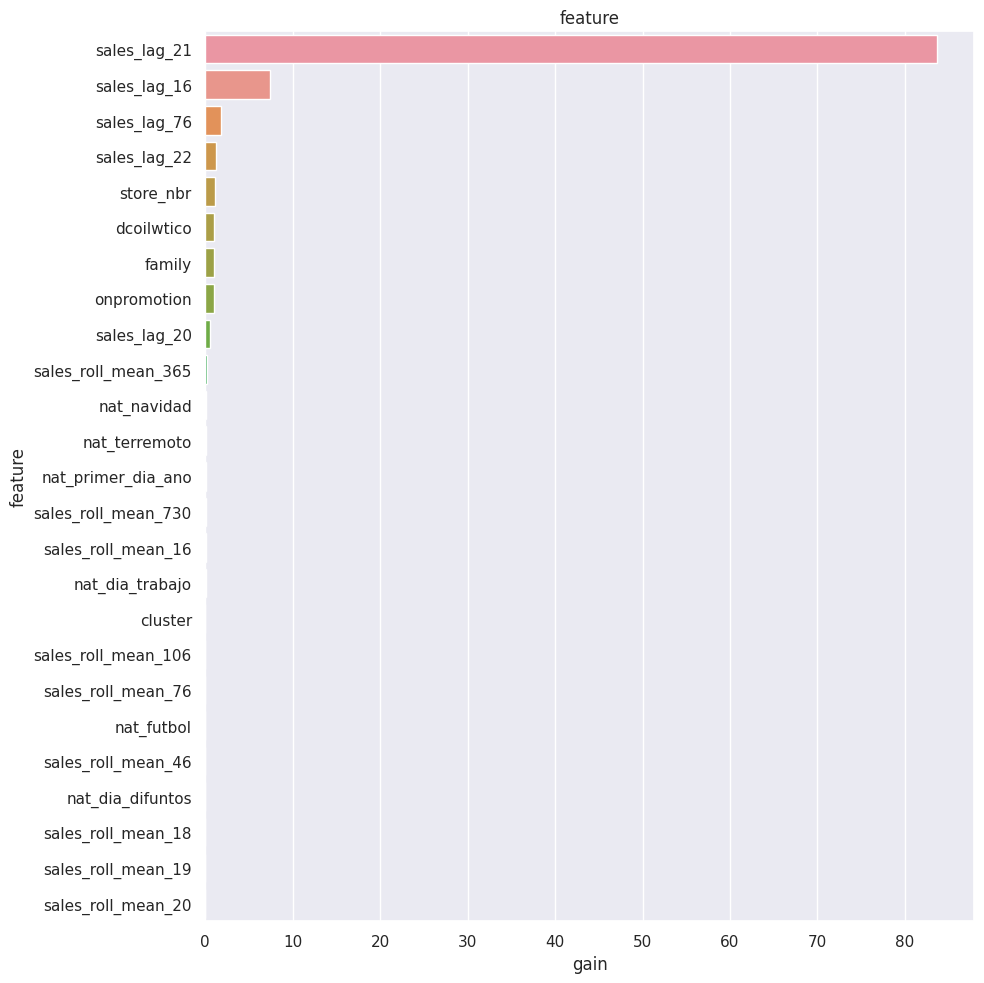

In [44]:
plot_lgb_importances(first_model, plot=True, num=10)

In [45]:
# feature importance
cols = feature_imp_df[feature_imp_df.gain > 0.015].feature.tolist()
print("Independent Variables:", len(cols))

Independent Variables: 22


In [46]:
X_train[cols]

,sales_lag_21,sales_lag_16,sales_lag_76,sales_lag_22,store_nbr,dcoilwtico,family,onpromotion,sales_lag_20,sales_roll_mean_365,nat_navidad,nat_terremoto,nat_primer_dia_ano,sales_roll_mean_730,sales_roll_mean_16,nat_dia_trabajo,cluster,sales_roll_mean_106,sales_roll_mean_76,nat_futbol,sales_roll_mean_46,nat_dia_difuntos
0,0.00,0.00,0.00,0.00,store_nbr_1,93.14,AUTOMOTIVE,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,cluster_13,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,store_nbr_9,93.14,HOME APPLIANCES,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.69,0.00,cluster_6,2.41,2.43,0.00,2.04,0.00
2,0.00,0.00,0.00,0.00,store_nbr_45,93.14,LINGERIE,0.00,0.00,4.32,0.00,0.00,1.00,3.76,3.56,0.00,cluster_11,3.73,3.50,0.00,3.57,0.00
3,0.00,0.00,0.00,0.00,store_nbr_9,93.14,HOME CARE,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.94,0.00,cluster_6,2.43,2.49,0.00,2.11,0.00
4,0.00,0.00,0.00,0.00,store_nbr_45,93.14,LAWN AND GARDEN,0.00,0.00,4.32,0.00,0.00,1.00,3.76,3.75,0.00,cluster_11,3.75,3.58,0.00,3.54,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2603497,0.00,0.00,0.00,0.00,store_nbr_54,53.40,LAWN AND GARDEN,0.00,0.00,628.77,0.00,0.00,1.00,657.44,659.66,0.00,cluster_3,683.11,697.93,0.00,695.08,0.00
2603498,8.00,5.00,8.00,3.00,store_nbr_39,53.40,PET SUPPLIES,1.00,10.00,679.10,0.00,0.00,1.00,645.35,723.35,0.00,cluster_6,691.08,681.87,0.00,688.93,0.00
2603499,26.00,8.00,50.00,7.00,store_nbr_42,53.40,LADIESWEAR,0.00,32.00,689.79,0.00,0.00,1.00,654.87,704.53,0.00,cluster_2,680.80,654.01,0.00,647.89,0.00
2603500,4.00,1.00,3.00,0.00,store_nbr_51,53.40,LINGERIE,0.00,3.00,621.43,0.00,0.00,1.00,654.94,645.68,0.00,cluster_17,587.49,593.00,0.00,610.58,0.00


## Model Development